In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.signal import butter, filtfilt, welch

In [32]:
data = pd.read_csv('data/train/Data_S06_Sess04.csv')
feedback_times = data[data['FeedBackEvent'] == 1]['Time']
fs = 200 # sampling frequency
default_channel = 'Fp1'

In [33]:
def get_part_after_feedback(feedback_id = 0):
    t = feedback_times.iloc[feedback_id]
    return data[(data['Time'] >= t - 0.2) & (data['Time'] <= t + 1.0)], t

def plot_part(part, t, channel = default_channel):
    time = (part['Time'] - t) * 1000 # convert to ms
    plt.plot(time, part[channel])
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage')
    plt.title(f'Channel {channel}')
    plt.show()

def bandpass_filter(part, channel = default_channel, lowcut = 1, highcut = 40, order = 5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_part = part.copy()
    filtered_part[channel] = filtfilt(b, a, part[channel])
    return filtered_part

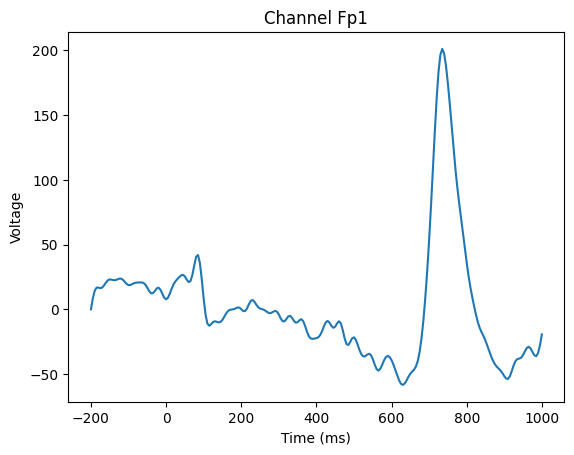

In [34]:
part, t = get_part_after_feedback(0)
filtered_part = bandpass_filter(part, highcut = 30) # remove noise, frequencies from bibliography
plot_part(filtered_part, t)

<class 'numpy.ndarray'>
Length of EEG segment: 241 samples


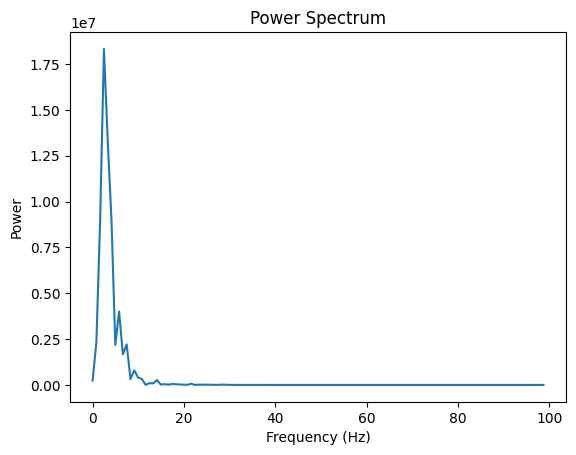

In [42]:
# We do spectral analysis on the filtered part (removed noise) so we can find which frequencies we should 
# focus on at the pre-processing stage

eeg_segment = filtered_part[default_channel].to_numpy()
print(f'{type(eeg_segment)}')
#print(f'eeg_segment: {eeg_segment}')

N = len(eeg_segment)
print(f'Length of EEG segment: {N} samples')
fft_vals = fft(eeg_segment)
freqs = np.fft.fftfreq(N, 1/fs)
power_spectrum = np.abs(fft_vals) ** 2

# Plot only the positive frequencies
plt.plot(freqs[:N // 2], power_spectrum[:N // 2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power Spectrum')
plt.show()

In [48]:
threshold = 0.85

positive_freqs = freqs[:N // 2]
positive_power = power_spectrum[:N // 2]

# Sort frequencies by power contribution (descending order)
sorted_indices = np.argsort(positive_power)[::-1]  # Sort descending
sorted_power = positive_power[sorted_indices]
sorted_freqs = positive_freqs[sorted_indices]

cumulative_power = np.cumsum(sorted_power)
total_power = cumulative_power[-1]  # Total power sum
normalized_cum_power = cumulative_power / total_power

threshold_index = np.where(normalized_cum_power >= threshold)[0][0]
dominant_freqs = sorted_freqs[:threshold_index + 1]

print(f'Frequencies containing {threshold * 100}% of the power: {dominant_freqs}')

low_freq = min(dominant_freqs)
high_freq = max(dominant_freqs)
print(f'Lowest freq = {low_freq}, Highest freq = {high_freq}')

Frequencies containing 85.0% of the power: [2.48962656 3.31950207 1.65975104 4.14937759 5.80912863 0.82987552]
Lowest freq = 0.8298755186721991, Highest freq = 5.809128630705394


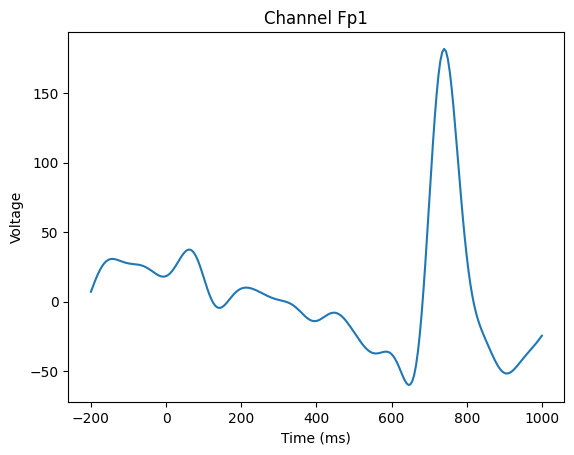

In [52]:
test_part = bandpass_filter(filtered_part, lowcut=0.2, highcut=10)
plot_part(test_part, t)